In [1]:
import os

os.chdir("../")
import lightkurve as lk
import matplotlib.pyplot as plt
import matplotlib as mpl
from scripts.analysis_tools_cython import *
from astropy.table import vstack

In [2]:
mpl.rcParams["figure.figsize"] = (15, 9)

In [3]:
lc = lk.search_lightcurve("TIC 270577175", author="SPOC")
lc

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 04,2018,SPOC,120,270577175,0.0
1,TESS Sector 05,2018,SPOC,120,270577175,0.0
2,TESS Sector 06,2018,SPOC,120,270577175,0.0
3,TESS Sector 07,2019,SPOC,120,270577175,0.0
4,TESS Sector 32,2020,SPOC,120,270577175,0.0
5,TESS Sector 33,2020,SPOC,120,270577175,0.0
6,TESS Sector 34,2021,SPOC,120,270577175,0.0


In [4]:
lcs = lc[0:4].download_all()

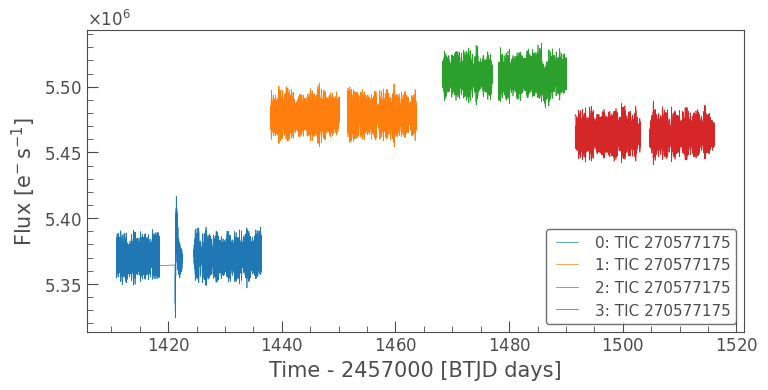

In [5]:
lcs.plot()

In [6]:
lcs_stitched = lcs.stitch()

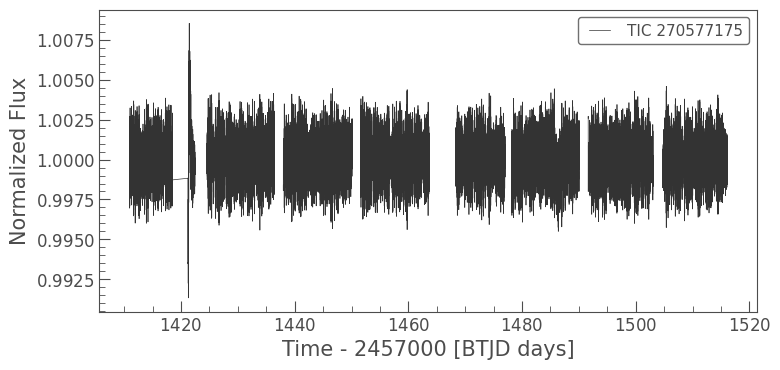

In [7]:
lcs_stitched.plot()

---

In [8]:
lc, _ = import_XRPlightcurve(
    "/storage/astro2/phrdhx/tesslcs/tesslcs_sector_6_104/2_min_cadence_targets/tesslc_270577175.pkl",
    sector=6,
)

In [9]:
lc2, _ = import_XRPlightcurve(
    "/storage/astro2/phrdhx/tesslcs/tesslcs_sector_7_104/2_min_cadence_targets/tesslc_270577175.pkl",
    sector=7,
)

In [10]:
lc3, _ = import_XRPlightcurve(
    "/storage/astro2/phrdhx/tesslcs/tesslcs_sector_5_104/2_min_cadence_targets/tesslc_270577175.pkl",
    sector=5,
)

### Taken from `lightkurve`

In [11]:
def stitch(self, corrector_func=lambda x: x.normalize()):
    """Stitch all light curves in the collection into a single `LightCurve`.

    Any function passed to `corrector_func` will be applied to each light curve
    before stitching. For example, passing "lambda x: x.normalize().flatten()"
    will normalize and flatten each light curve before stitching.

    Parameters
    ----------
    corrector_func : function
        Function that accepts and returns a `~lightkurve.lightcurve.LightCurve`.
        This function is applied to each light curve in the collection
        prior to stitching. The default is to normalize each light curve.

    Returns
    -------
    lc : `~lightkurve.lightcurve.LightCurve`
        Stitched light curve.
    """
    if corrector_func is None:
        corrector_func = lambda x: x  # noqa: E731
    with warnings.catch_warnings():  # ignore "already normalized" message
        warnings.filterwarnings("ignore", message=".*already.*")
        lcs = [corrector_func(lc) for lc in self]

    # Address issue #954: ignore incompatible columns with the same name
    columns_to_remove = set()
    for col in lcs[0].columns:
        for lc in lcs[1:]:
            if col in lc.columns:
                if not (
                    issubclass(lcs[0][col].__class__, lc[col].__class__)
                    or issubclass(lc[col].__class__, lcs[0][col].__class__)
                    or lcs[0][col].__class__.info is lc[col].__class__.info
                ):
                    columns_to_remove.add(col)
                    continue

    if len(columns_to_remove) > 0:
        warnings.warn(
            f"The following columns will be excluded from stitching because the column types are incompatible: {columns_to_remove}",
            LightkurveWarning,
        )
        lcs = [lc.copy() for lc in lcs]
        [lc.remove_columns(columns_to_remove.intersection(lc.columns)) for lc in lcs]

    # Need `join_type='inner'` until AstroPy supports masked Quantities
    return vstack(lcs, join_type="inner", metadata_conflicts="silent")

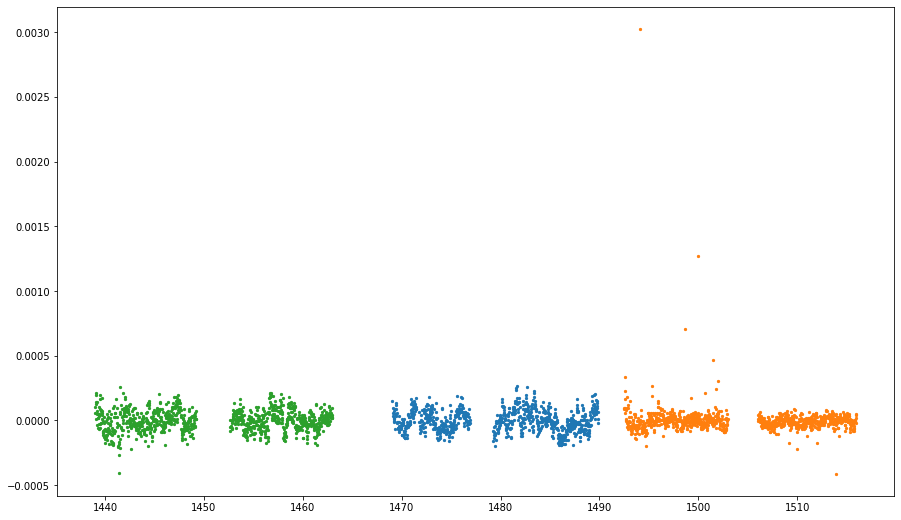

In [12]:
plt.scatter(lc["time"], normalise_flux(lc["corrected flux"]), s=5)
plt.scatter(lc2["time"], normalise_flux(lc2["corrected flux"]), s=5)
plt.scatter(lc3["time"], normalise_flux(lc3["corrected flux"]), s=5)

In [13]:
new_table = vstack([lc3, lc, lc2], join_type="inner")

In [14]:
lc["corrected flux"] = normalise_flux(lc["corrected flux"])
lc2["corrected flux"] = normalise_flux(lc2["corrected flux"])
lc3["corrected flux"] = normalise_flux(lc3["corrected flux"])

In [15]:
new_table2 = vstack([lc3, lc, lc2], join_type="inner")
new_table2

time,raw flux,corrected flux,PCA flux,flux error,quality
float64,float64,float64,float64,float64,int32
1439.0123416701817,221182.74890551923,0.00010233645818757964,221263.02040823633,12.787467805853597,0
1439.0331752568609,221171.39868890672,5.729249623187549e-05,221270.73399950768,12.787269722961717,0
1439.054008844922,221179.58573301148,9.187633047691435e-06,221247.45746674927,12.787267038082167,0
1439.0748424344265,221155.9932618547,0.00020819768624669166,221334.37203765972,12.787883650617045,0
1439.0956760254082,221132.4007906979,0.00014366147883015934,221288.9386897132,12.78768438092573,0
1439.1165096178709,221138.52104207914,0.0001263041536130327,221310.26865355176,12.787688258958331,0
1439.1373432117891,221144.6412934604,0.00019597587364739155,221245.09989543504,12.787890213338494,0
1439.1581768071128,221124.10802720996,5.2878944053702526e-05,221173.03159981713,12.787279865834934,0
1439.1790104037595,221116.32307873032,0.0001384031628544058,221269.0850760681,12.787482721609782,0


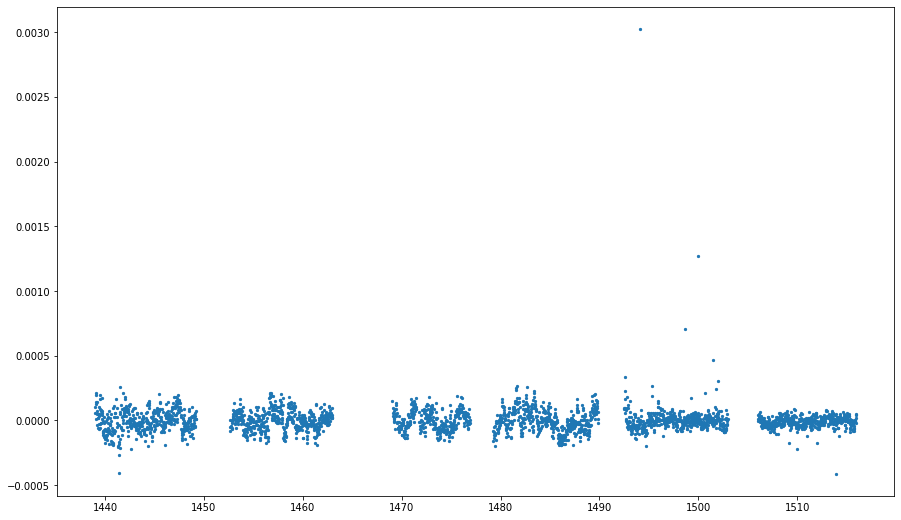

In [16]:
plt.scatter(new_table2["time"], new_table2["corrected flux"], s=5)

We can stitch our lightcurves!